#### SNNのFeedForwardの実装
- 最終的な式は
$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{S[t]U_{\rm thr}}_\text{reset} $$ 

1. W : 入力に対する重みで学習可能
1. S : 発火した時にリセットする項
1. β : 遅延度合い

In [1]:
import snntorch as snn
from snntorch import spikeplot as splt 
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
def leaky_integrate_and_fire(mem,x,w,beta,threshold=1):
    spk=(mem > threshold)
    mem=beta*mem + w*x - spk*threshold
    return spk,mem

#### βの値の設定

- 以下の２式から値が確定する
$$U(t) = U_0e^{-\frac{t}{\tau}}$$
$$\beta = \frac{U_0e^{-\frac{t+\Delta t}{\tau}}}{U_0e^{-\frac{t}{\tau}}} = \frac{U_0e^{-\frac{t + 2\Delta t}{\tau}}}{U_0e^{-\frac{t+\Delta t}{\tau}}} =~~...$$
$$\implies \beta = e^{-\frac{\Delta t}{\tau}} $$


In [3]:
delta_t=torch.tensor(1e-3)
tau=torch.tensor(5e-3)
beta=torch.exp(-delta_t/tau)

print(f'遅延率は : {beta:.3f}')


遅延率は : 0.819


#### 入力と発火の様子の図示

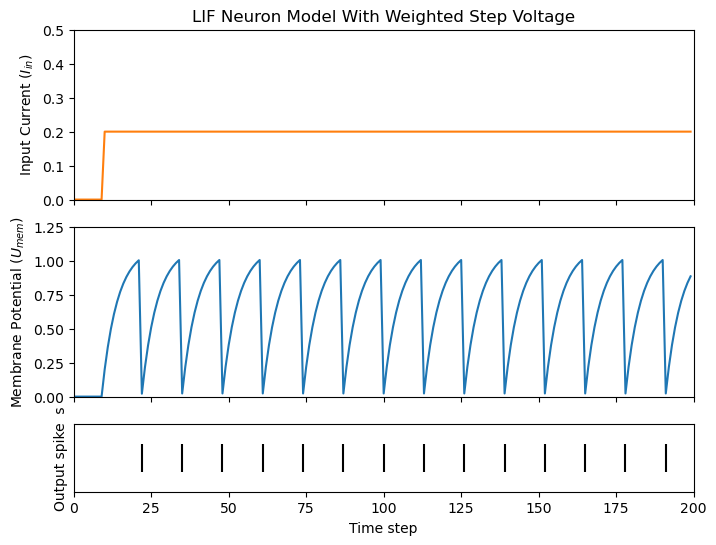

In [4]:
class SNN_input:
    def __init__(self,x,w,mem,delta,tau,threshold,spk_out,num_step=200):
        self.x=x
        self.w=w
        self.mem=mem
        self.spk_out=spk_out
        self.delta=delta
        self.tau=tau
        self.threshold=threshold
        self.num_step=num_step
        self.mem_rec=[]
        self.spk_rec=[]

    def calculate_beta(self):
        beta=torch.exp(-self.delta/self.tau)
        return beta

    def leaky_integrate_and_fire(self,x):
        self.spk=(self.mem > self.threshold)
        self.mem=self.calculate_beta()*self.mem + self.w*x - self.spk*self.threshold
        return self.spk,self.mem
    
    def neuron_simulation(self):
        for step in range(self.num_step):
            self.spk,self.mem=self.leaky_integrate_and_fire(self.x[step])
            self.mem_rec.append(self.mem)
            self.spk_rec.append(self.spk)

    def plot_cur_mem_spk(self,title=False,save=False,path=None,
                        ylim_max1=1.25,ylim_max2=1.25):

        mem_rec = torch.stack(self.mem_rec)
        spk_rec = torch.stack(self.spk_rec)
        fig,ax=plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})
        
        ax[0].plot(self.x*self.w,c='tab:orange')
        ax[0].set_ylim([0, ylim_max1])
        ax[0].set_xlim([0, self.num_step])
        ax[0].set_ylabel("Input Current ($I_{in}$)")
        if title:
            ax[0].set_title(title)

        ax[1].plot(mem_rec)
        ax[1].set_ylim([0, ylim_max2]) 
        ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
        plt.xlabel("Time step")

        splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
        plt.ylabel("Output spike  s")
        plt.yticks([]) 
        if save:
            plt.savefig(path)
        plt.show()

        
mem_rec=SNN_input(x=torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0),
                w=0.4,
                mem=torch.zeros(1),
                spk_out= torch.zeros(1),
                delta=torch.tensor(1e-3),
                tau=torch.tensor(5e-3),
                threshold=1)

mem_rec.neuron_simulation()#これをインスタンス化しないとsimulationが行われない
mem_rec.plot_cur_mem_spk(title='LIF Neuron Model With Weighted Step Voltage' ,
                        save=True,
                        path='Images/LIF_Neuron_Step_Voltage.png',
                        ylim_max1=0.5)

#### より簡単な方法でスパイクを出す(leaky_integrate_fireのところ)
- lif1にニューロンモデルを格納する

In [5]:
lif1=snn.Leaky(beta=0.8)

**入力**
* `cur_in`: 時間ごとの $W\times X[t]$ を入力とする
* `mem`: 一つ前の時間の膜電位 $U[t-1]$, も入力とする

**出力**
* `spk_out`:　出力のスパイク $S[t]$ (発火したら'1' しなかったら'0')
* `mem`: 今の時間の膜電位 $U[t]$ 


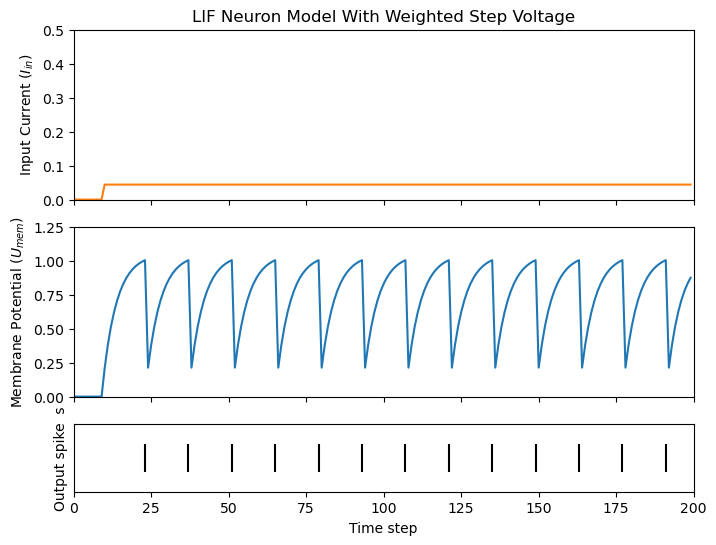

In [6]:
class SNN_input2:
    def __init__(self,w,x,mem,beta,spk_out,threshold=1,num_step=200):
        self.x=x
        self.w=w
        self.mem=mem
        self.spk_out=spk_out
        self.beta=beta
        self.threshold=threshold
        self.num_step=num_step
        self.mem_rec=[]
        self.spk_rec=[]

    def neuron_simulation(self):
        lif=snn.Leaky(self.beta)
        
        for step in range(self.num_step):
            self.spk,self.mem=lif(self.x[step],self.mem)
            self.mem_rec.append(self.mem)
            self.spk_rec.append(self.spk)

    def plot_cur_mem_spk(self,title=False,save=False,path=None,
                        ylim_max1=1.25,ylim_max2=1.25):

        mem_rec = torch.stack(self.mem_rec)
        spk_rec = torch.stack(self.spk_rec)
        figure,ax=plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})
        
        ax[0].plot(self.x*self.w,c='tab:orange')
        ax[0].set_ylim([0, ylim_max1])
        ax[0].set_xlim([0, self.num_step])
        ax[0].set_ylabel("Input Current ($I_{in}$)")
        if title:
            ax[0].set_title(title)

        ax[1].plot(mem_rec)
        ax[1].set_ylim([0, ylim_max2]) 
        ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
        plt.xlabel("Time step")

        splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
        plt.ylabel("Output spike  s")
        plt.yticks([]) 
        if save:
            plt.savefig(path)
        plt.show()

w=0.21
mem_rec2=SNN_input2(w=w,
                    x= torch.cat((torch.zeros(10), torch.ones(190)*w), 0),
                    mem=torch.zeros(1),
                    beta=0.8,
                    spk_out=torch.zeros(1)
                    )

mem_rec2.neuron_simulation()
mem_rec2.plot_cur_mem_spk(title='LIF Neuron Model With Weighted Step Voltage' ,
                        ylim_max1=0.5)


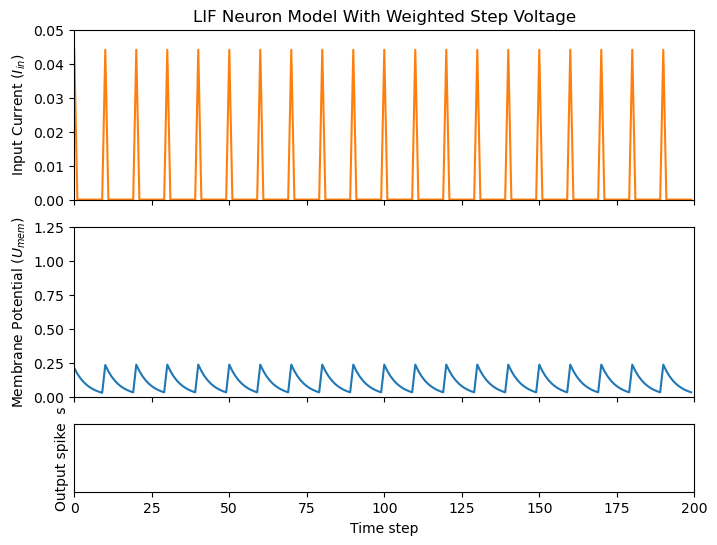

In [7]:
spk_period = torch.cat((torch.ones(1)*w, torch.zeros(9)), 0)
spk_in = spk_period.repeat(20)


mem_rec3=SNN_input2(x=spk_in,
                    w=w,
                    mem=torch.zeros(1),
                    beta=0.8,
                    spk_out=torch.zeros(1),
                    threshold=0.10
                    )

mem_rec3.neuron_simulation()
mem_rec3.plot_cur_mem_spk(title='LIF Neuron Model With Weighted Step Voltage' ,
                        ylim_max1=0.05)

#### いよいよFeedForwardの実装

<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_8_fcn.png?raw=true' width="600">

##### お待ちかねの順伝播の時間です

- ニューロン間の接続にはpytorchを、ニューロンの作成はsnntorchを使う

In [8]:
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

num_steps=200

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

- 各スパイクの入力と隠れ変数と出力を初期化する

In [9]:
#.init_leaky()は初期化するメソッド
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

#出力の設定
mem2_rec = []
spk1_rec = []
spk2_rec = []

- 適当な初期値を与えてみる。time_step:200で<br>
入力の次元が784のものを入力とした
- これはランダムなスパイクでMNISTの次元こそあれ数字としては成立していない

- 入力の次元は　[Time_step , Batch_size , Feature_dimensions]でないといけない

In [10]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
#.unsqueezeで次元を追加する
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([200, 1, 784])


#### 学習の過程について
- spk_inからのi番目とj番目のニューロンの重みはnn.Linear
- スパイクがなければ次のニューロンには何も渡されない
- nn.Linearで生成された重みで入力をスケーリングしている

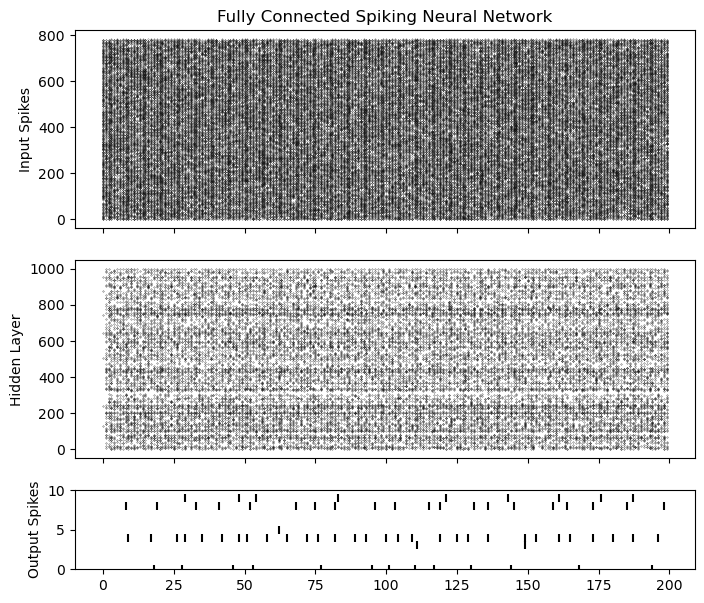

In [11]:
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

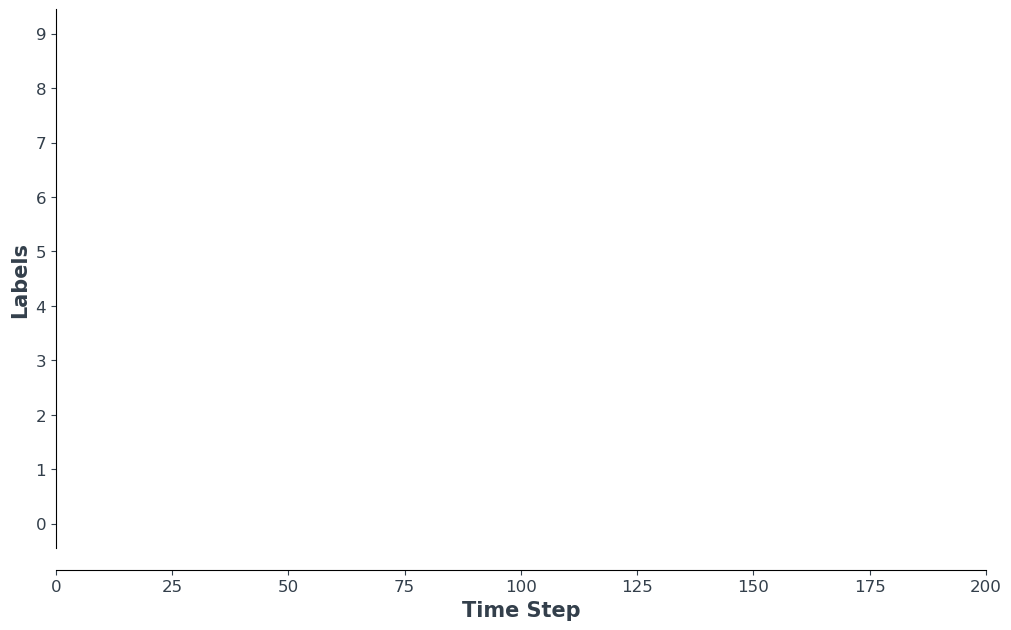

In [12]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")